# Tutorial 5 -- Solutions 

Author: "Sarah Filippi".

# Question 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
train_data = pd.read_csv('train_dataQ1.csv')
test_data = pd.read_csv('test_dataQ1.csv')
train_data.head()

,x,y
0,-4.999160,0.096613
1,-4.998336,0.205008
2,-4.996968,0.193982
3,-4.989036,0.161042
4,-4.981637,0.191798


In [3]:
x_train, y_train = train_data['x'].values, train_data['y'].values
x_test, y_test = test_data['x'].values, test_data['y'].values

In [5]:
# Subsample the training set
CID = 1234567
np.random.seed(CID)
subsample_inx = np.random.choice(np.arange(x_train.shape[0]), 200,replace=False)
x_train, y_train = x_train[subsample_inx], y_train[subsample_inx]

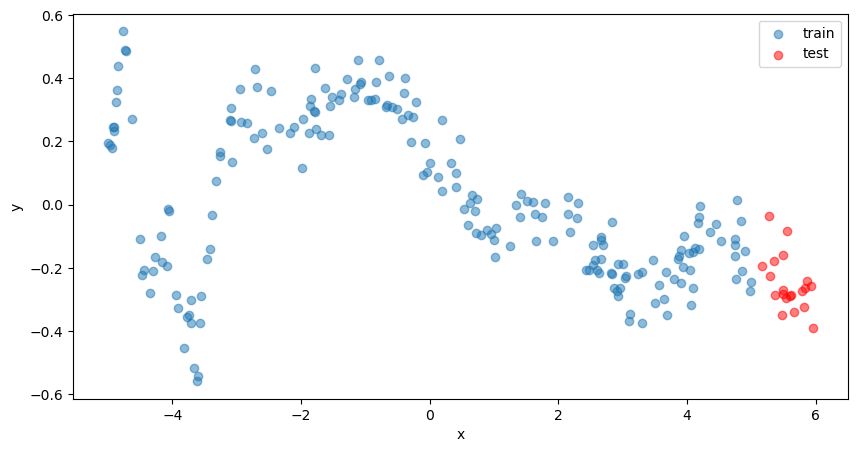

In [7]:
# Plot the training and test data
plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, alpha=0.5, label="train")
plt.scatter(x_test, y_test, c='red', alpha=0.5, label="test")
plt.xlabel("x")
plt.ylabel("y")
# plt.title("Training and test data")
plt.legend(loc='upper right')
plt.show()

We now need to learn two hyperparameters for the kernel ridge regression model with the given kernel: the polynomial degree (p) and the regularization parameter (lambda). To learn those, we will sub-divide the training set into a training set and a validation set. We will consider a grid of values for the hyperparameters, train the models with these values on the training set and compare their errors on the validation set. 

Note that we do not use the test set at all in this part. 

Instead of this procedure, we could use some cross-validation scheme.

In [9]:
# For the kernel regression, make train/valid splits
from sklearn.model_selection import train_test_split
np.random.seed(1)
x_train_k, x_val_k, y_train_k, y_val_k = train_test_split(x_train, y_train,test_size=0.2)

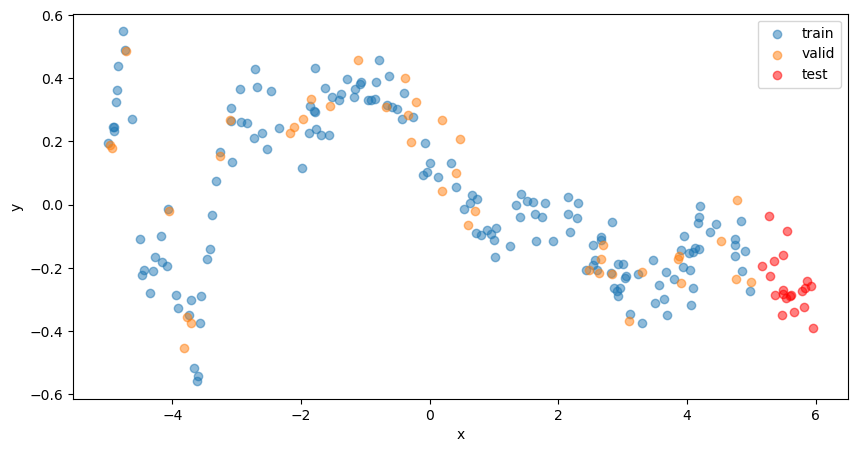

In [10]:
# Plot the training, validation and test data
plt.figure(figsize=(10, 5))
plt.scatter(x_train_k, y_train_k, alpha=0.5, label="train")
plt.scatter(x_val_k, y_val_k, alpha=0.5, label="valid")
plt.scatter(x_test, y_test, c='red', alpha=0.5, label="test")
plt.xlabel("x")
plt.ylabel("y")
# plt.title("Training, validation and test data for kernel regression")
plt.legend(loc='upper right')
plt.show()

We now define the polynomial kernel and a few useful functions.

In [14]:
def poly_kernel(x1, x2, scale=1., bias=1., order=1.):
    """NB: x1 and x2 should have shape [n_samples, dim]"""
    return (bias + (scale * np.tensordot(x1, x2.T, axes=1)))**order

def posterior_mean(x_test, x, y, reg, k):
    N = y.shape[0]
    KxX = k(x_test, x)
    KXX = k(x, x)
    Kinv = np.linalg.inv(KXX + reg * np.eye(N))
    Kinvy = Kinv @ y
    return KxX @ Kinvy

def mse(y, y_pred):
    return np.mean(np.square(y - y_pred))

We now consider the grid of hyperparameters and fit the models for each of these values, returning the MSE on the training, validation and test sets

In [15]:
from functools import partial

regs = [0.1, 1, 10]
orders = [3, 4, 5, 6, 7]
results = []
x_plot_range = np.linspace(-5, 6, 200)
best_val = [np.inf, None]
for order in orders:
    for reg in regs:
        kernel_regressor = partial(posterior_mean, x=x_train_k[..., None],y=y_train_k[..., None], reg=reg, k=partial(poly_kernel, order=order))
        y_pred = kernel_regressor(x_plot_range[..., None])
        train_mse = mse(np.squeeze(kernel_regressor(x_train_k[..., None])),y_train_k)
        val_mse = mse(np.squeeze(kernel_regressor(x_val_k[..., None])), y_val_k)
        test_mse = mse(np.squeeze(kernel_regressor(x_test[..., None])), y_test)
        results.append({"order": order, "reg": reg, "train_mse": train_mse,"val_mse": val_mse, "test_mse": test_mse, "y_pred": y_pred})
        if val_mse < best_val[0]:
            best_val = [val_mse, len(results) - 1]


We obtain the following table of results

In [18]:
results_df = pd.DataFrame(results).drop('y_pred', axis=1)
results_df

,order,reg,train_mse,val_mse,test_mse
0,3,0.1,0.041285,0.042394,0.009966
1,3,1.0,0.041286,0.042428,0.010106
2,3,10.0,0.041380,0.042817,0.011391
3,4,0.1,0.030232,0.028751,0.730850
4,4,1.0,0.030240,0.028780,0.715886
5,4,10.0,0.030810,0.029653,0.600221
6,5,0.1,0.018685,0.017621,0.230585
7,5,1.0,0.018693,0.017617,0.236593
8,5,10.0,0.019231,0.018208,0.282441
9,6,0.1,0.015888,0.019580,0.367966


We now plot the fit of the kernel ridge regression with different values of the hyper-parameters

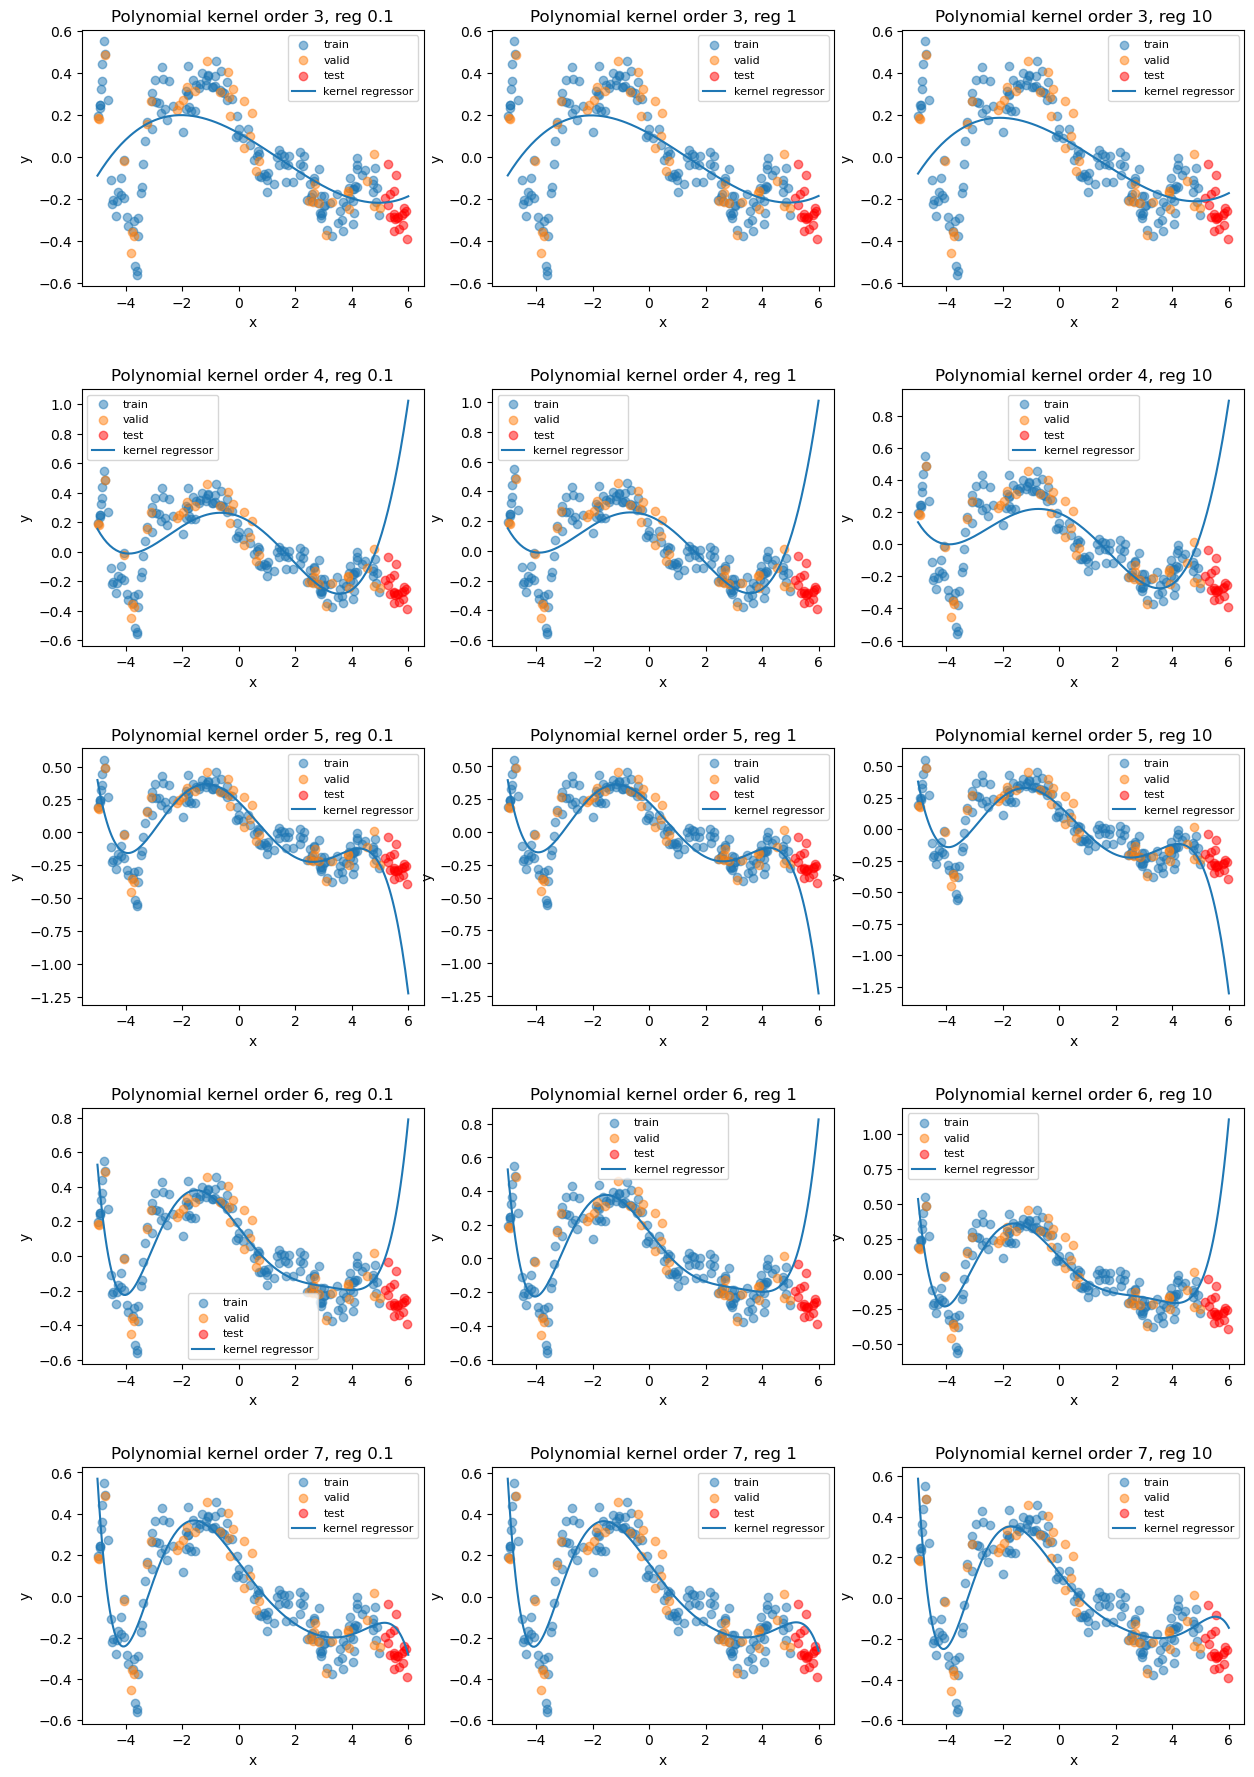

In [19]:
fig = plt.figure(figsize=(15, 22))
plt.subplots_adjust(hspace=0.4)
for row in range(5):
    for col in range(3):
        i = (row*3) + col
        order = results[i]['order']
        reg = results[i]['reg']
        y_pred = results[i]['y_pred']
        fig.add_subplot(5, 3, i+1)
        plt.scatter(x_train_k, y_train_k, alpha=0.5, label="train")
        plt.scatter(x_val_k, y_val_k, alpha=0.5, label="valid")
        plt.scatter(x_test, y_test, c='red', alpha=0.5, label="test")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Polynomial kernel order {}, reg {}".format(order, reg))
        plt.plot(x_plot_range, y_pred, label='kernel regressor')
        plt.legend(fontsize=8)
plt.show()

We identify the hyper-parameters that minimise the validation error

In [21]:
print("Best validation model:")
results_df.iloc[best_val[1]]

Best validation model:


order        5.000000
reg          1.000000
train_mse    0.018693
val_mse      0.017617
test_mse     0.236593
Name: 7, dtype: float64

# Question 2

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Tuple
from scipy.stats import norm
from __future__ import annotations

# set a random seed
seed = 1
np.random.seed(seed)


Load data

In [3]:
df = pd.read_csv("dataQ3.csv")
df.rename(columns={"Months.since.Jan.1960": "t"}, inplace=True)


Text(0, 0.5, 'Temperature')

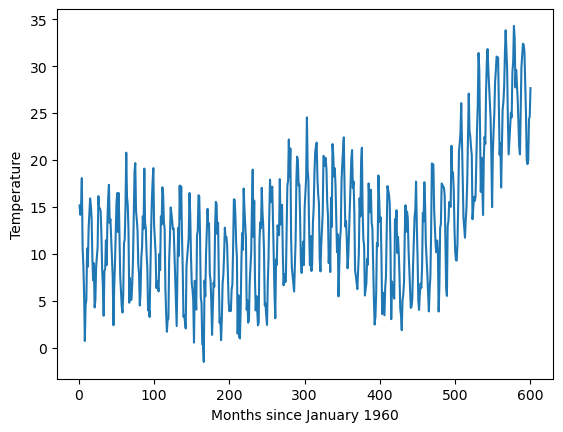

In [4]:
plt.plot(df["t"], df["temp"])
plt.xlabel("Months since January 1960")
plt.ylabel("Temperature")


## Part 1

The answer to the first two parts of this question draws heavily from Chapter 2 of Gaussian Processes for Machine Learning by Rasmussen and Williams, which you can find online for free.

We define the following Bayesian linear regression model for $y_t$, the observed temperature $t$ months after January 1960:

$$
  y_t =f_t + \varepsilon_t \,, \quad f_t = \boldsymbol{\phi}(x_t)^T \boldsymbol{\beta} \,, \quad \varepsilon_t \sim \mathcal{N}(0,\sigma^2) \,, \quad t = 1\,, \ldots\,,T \,,
$$

where $\boldsymbol{\beta} = (\beta_0, \ldots \,, \beta_p)^T \in \mathbb{R}^{p+1}$ are the model parameters and $\boldsymbol{\phi}(x) = (1, \phi_1(x), \ldots)$ is a feature map that maps the scalar input to a $p$-dimensional feature space. The variance $\sigma^2$ is fixed and assumed to be known. $f$ denotes the latent function value.

We also specify a zero-mean diagonal prior over $\boldsymbol{\beta}$ such that $\boldsymbol{\beta} \sim \mathcal{N}(\mathbf{0}, \alpha \mathbf{I})$, where $\alpha$ is a positive constant and $\mathbf{I}$ is the identity matrix.

We define the matrices $\mathbf{X} \in \mathbb{R}^{T \times 1}$ which contains the time points on each row and $\boldsymbol{\Phi}=\boldsymbol{\Phi}(\mathbf{X}) \in \mathbb{R}^{T \times (p+1)}$, which contains the time points in the feature space on each row. We also collect the observed temperatures into the vector $\mathbf{y} = (y_1, \ldots \,, y_T)^T \in \mathbb{R}^T$. The corresponding latent values are stored in the vector $\mathbf{f} = (f_1, \ldots \,, f_T)^T \in \mathbb{R}^T$.

The posterior distribution over the parameters is given by Bayes' Theorem and is the Gaussian $\boldsymbol{\beta} \mid \mathbf{y}, \mathbf{X}, \sigma^2, \alpha \sim \mathcal{N}(\boldsymbol{\mu}, \mathbf{A}^{-1})$ where
$$
  \boldsymbol{\mu} = \sigma^{-2} \mathbf{A}^{-1} \boldsymbol{\Phi}^T \mathbf{y} \,,
$$
and
$$
  \mathbf{A} = \sigma^{-2} \left(\boldsymbol{\Phi}^T \boldsymbol{\Phi} + \dfrac{1}{\alpha} \mathbf{I}\right)  \,.
$$


Consider the prediction of the function evaluated at a set of $n^*$ unseen test points $\mathbf{X}^* \in \mathbb{R}^{n^* \times 1}$; denote  $\mathbf{f}^* = (f(\mathbf{X}^*_1), \ldots \, f(\mathbf{X}^*_{n^*}))^T \in \mathbb{R}^{n^*}$. We have 
$$
  \mathbf{f}^* \mid \mathbf{X}, \mathbf{X}^* , \mathbf{y} = \int p(\mathbf{f}^* \mid \mathbf{X}^*, \boldsymbol{\beta}) \, p(\boldsymbol{\beta} \mid \mathbf{y}, \mathbf{X}) \, \text{d} \boldsymbol{\beta} \,,
$$
where $\mathbf{X}^*$ and $\boldsymbol{\Phi}^*$ are defined similarly to $\mathbf{X}$ and $\boldsymbol{\Phi}$ respectively. The predictive posterior is another Gaussian with mean equal to the projection of the 
$$
\mathbb{E}[\mathbf{f}^* \mid \mathbf{X}, \mathbf{X}^* , \mathbf{y}] = \boldsymbol{\Phi}^* \boldsymbol{\mu}
$$
and variance
$$
\mathbb{V}[\mathbf{f}^* \mid \mathbf{X}, \mathbf{X}^* , \mathbf{y}, \sigma^2] = \boldsymbol{\Phi}^* \mathbf{A}^{-1} \boldsymbol{\Phi}^*{^T} \,.
$$

In addition, consider $\mathbf{y}^*\in \mathbb{R}^{n^*}$ such that 
$$\mathbf{y}^*_i=\mathbf{f}^*_i+\epsilon_i\,, \quad \epsilon_i\sim \mathcal{N}(0,\sigma^2) \,, \quad t = i\,, \ldots\,,n^* \,.$$
Then $\mathbf{y}^*$ also follows a normal distribution with

$$
\mathbb{E}[\mathbf{y}^* \mid \mathbf{X}, \mathbf{X}^* , \mathbf{y}] = \boldsymbol{\Phi}^* \boldsymbol{\mu}
$$
and variance
$$
\mathbb{V}[\mathbf{y}^* \mid \mathbf{X}, \mathbf{X}^* , \mathbf{y}, \sigma^2] = \boldsymbol{\Phi}^* \mathbf{A}^{-1} \boldsymbol{\Phi}^*{^T}+\sigma^2 \mathbf{I}\,.
$$

## Part 2

A Gaussian process $\mathcal{GP}(m(\cdot), k(\cdot,\cdot))$ is fully determined by its mean function $m(\cdot)$ and positive semi-definite kernel function $k(\cdot,\cdot)$. Consider the Bayesian linear regression model described in the previous question where $f(x) = \boldsymbol{\phi}(x)^T \boldsymbol{\beta}$ and $\boldsymbol{\beta} \sim \mathcal{N}(\mathbf{0}, \alpha \mathbf{I})$. For every $x$, 
$$
  \mathbb{E}[f(x)] = \boldsymbol{\phi}(x)^T \mathbb{E}[\boldsymbol{\beta}] = 0
$$
and for everey $x$ and $x'$
$$
\text{cov}[f(x), f(x')] = \mathbb{E}[f(x) f(x')^T] = \boldsymbol{\phi}(x)^T \mathbb{E}[\boldsymbol{\beta}\boldsymbol{\beta}^T] \boldsymbol{\phi}(x') = \alpha \boldsymbol{\phi}(x)^T \boldsymbol{\phi}(x') \,.
$$

Therefore a pair of function values from the Bayesian linear regression model are jointly Gaussian with zero mean and a positive semi-definite covariance equal to $\alpha \boldsymbol{\phi}(x_t)^T \boldsymbol{\phi}(x_{t'})$. The the Bayesian linear regression model is therefore equivalent to a Gaussian process with a kernel $k$ defined as follows:
$$k(x,x')=\alpha \boldsymbol{\phi}(x)^T \boldsymbol{\phi}(x')\,.$$

We can easily prove that this is a valid kernel by showing that

* it is symmetric: for all $x,x'$, $k(x,x')=k(x'x,)$
* it is positive semi-definite as $k(x,x')= v(x)^Tv(x')$ where $v(x)=\sqrt\alpha \boldsymbol{\phi}(x)$.

## Part 3

We will consider three models with the following kernels:

* a radial basis function (RBF, also called squared exponential) kernel
* a periodic kernel
* a product of an RBF and periodic kernel

The kernels are defined as in the [Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/). *In any assessment/coursework, you are expected to precisely write down the equations of the kernels you are using, defining all the hyperparameters.*

The code below implements the RBF and periodic kernels.

In [5]:
# Define a base class for kernels
class Kernel:
    """Base class for kernels"""

    def __add__(self, kernel2: Kernel):
        return SumKernel([self, kernel2])

    def __mul__(self, kernel2: Kernel):
        return ProductKernel([self, kernel2])

# Define a kernel class for summation of kernels
class SumKernel:
    """Kernel to enable summation of kernels"""

    def __init__(self, kernels: List[Kernel]) -> None:
        self.kernels = kernels

    def __call__(self, X: np.ndarray, X2: np.ndarray = None) -> np.ndarray:
        return np.sum([k(X, X2) for k in self.kernels], axis=0)

# Define a kernel class for product of kernels
class ProductKernel:
    """Kernel to enable product of kernels"""

    def __init__(self, kernels: List[Kernel]) -> None:
        self.kernels = kernels

    def __call__(self, X: np.ndarray, X2: np.ndarray = None) -> np.ndarray:
        return np.prod([k(X, X2) for k in self.kernels], axis=0)

# Define a kernel class for the RBF kernel
class RBF(Kernel):
    def __init__(
        self, sigma_f: np.float64 = 1.0, lengthscale: np.float64 = 1.0
    ) -> None:
        self.sigma_f = sigma_f
        self.lengthscale = lengthscale

    def __call__(self, X: np.ndarray, X2: np.ndarray = None) -> np.ndarray:
        """
        Calculate a kernel matrix using the RBF kernel

        Args:
        - X: matrix with shape n1 x 1
        - X2: matrix with shape n2 x 1 or None (default), in which case X2=X

        Returns: n1 x n2 kernel matrix
        """

        if X2 is None:
            X2 = X

        # we make use of broadcasting to compute the pairwise difference
        # between each element of X and X2
        diff = (X[:, None, 0] - X2[None, :, 0]) ** 2
        K = self.sigma_f ** 2 * np.exp(-diff / (2 * self.lengthscale ** 2))
        return K

# Define a kernel class for the periodic kernel
class PeriodicKernel(Kernel):
    def __init__(
        self,
        sigma_f: np.float64 = 1.0,
        lengthscale: np.float64 = 1.0,
        period: np.float64 = 1.0,
    ) -> None:
        self.sigma_f = sigma_f
        self.lengthscale = lengthscale
        self.period = period

    def __call__(self, X: np.ndarray, X2: np.ndarray = None) -> np.ndarray:
        """
        Calculate a kernel matrix using the periodic kernel function

        Args:
        - X: matrix with shape n1 x 1
        - X2: matrix with shape n2 x 1 or None (default), in which case X2=X

        Returns: n1 x n2 kernel matrix
        """

        if X2 is None:
            X2 = X

        # we make use of broadcasting to compute the pairwise difference
        # between each element of X and X2
        diff = np.abs(X[:, None, 0] - X2[None, :, 0])
        K = -2 * np.sin(np.pi * diff / self.period) ** 2
        K = self.sigma_f ** 2 * np.exp(K / self.lengthscale ** 2)
        return K


Drawing samples from GP priors with each kernel using different hyperparameter values enables us to see the effect of the hyperparameters.

We start with the RBF kernel and vary both hyperparameters on a coarse grid. The shaded area indicates the 95% credible interval.

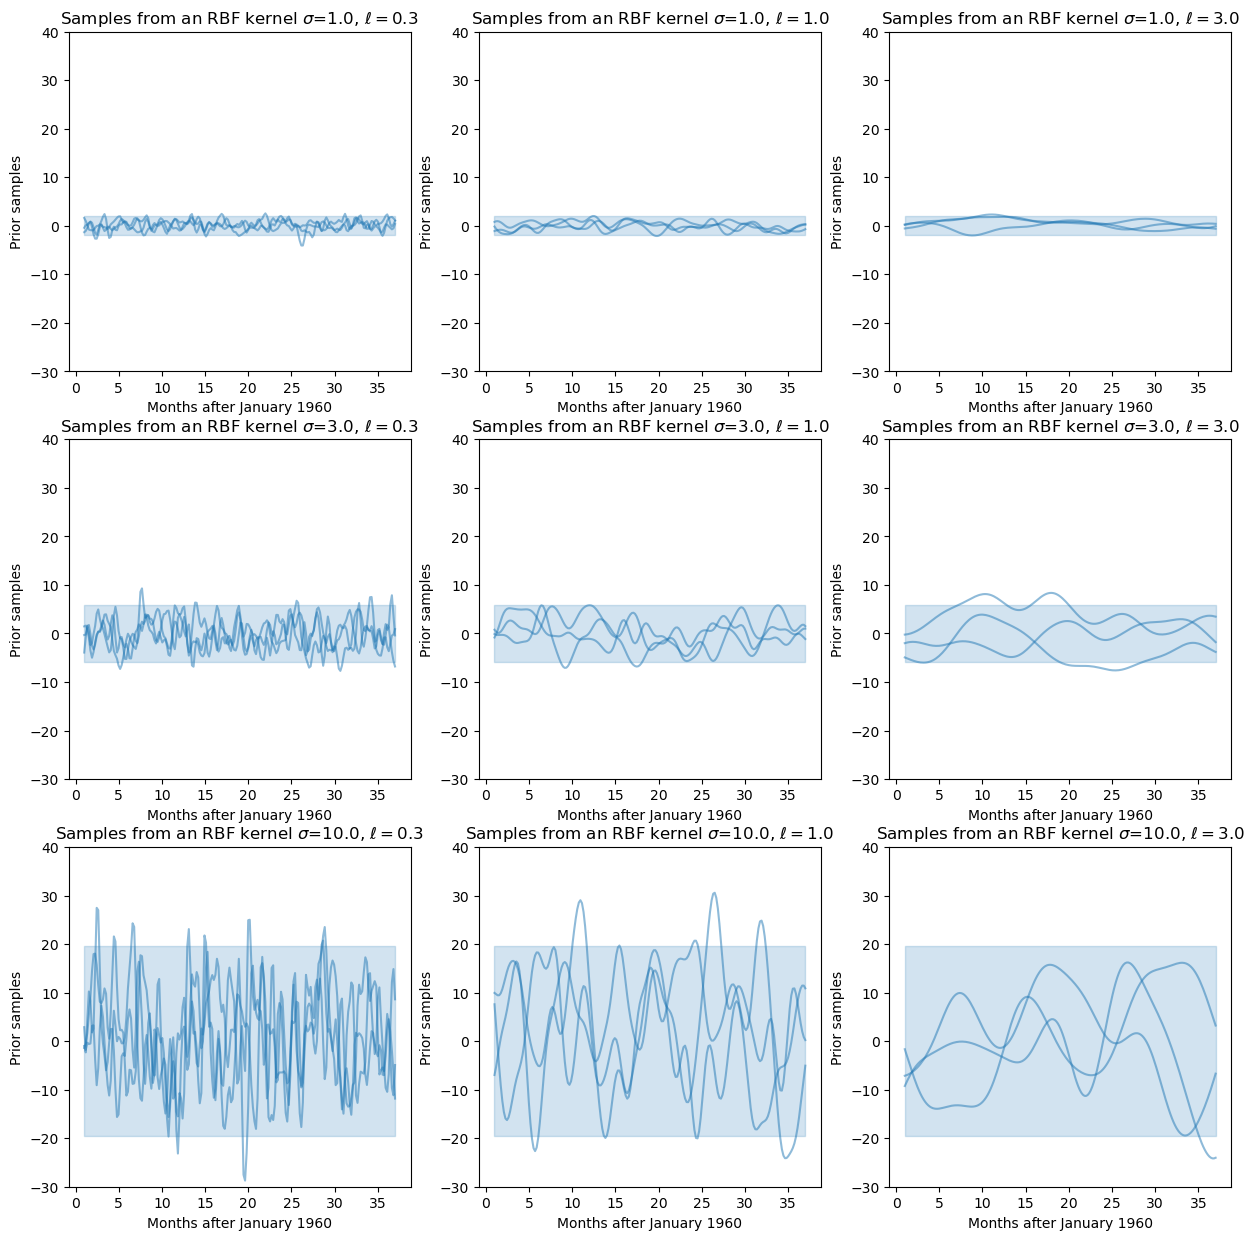

In [6]:
# Number of samples to draw from the GP prior
n_samples = 3
# X values at which to draw the GP prior
X = np.linspace(df["t"][0], df["t"][35], 200)[:, None]

# Values of the hyperparameters to plot
sigma_fs = [1.0, 3.0, 10.0]
lengthscales = [0.3, 1.0, 3.0]

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, sigma_f in enumerate(sigma_fs):
    for j, lengthscale in enumerate(lengthscales):
        # Intialise a kernel with the given hyperparameters
        k = RBF(sigma_f, lengthscale)
        # Compute kernel matrix for the input X
        K = k(X)
        var = np.diag(K)
        # Take cholesky decomposition K = LL^T
        # Add small jitter 1e-6 for better matrix conditioning
        L = np.linalg.cholesky(K + 1e-6 * np.eye(K.shape[0]))
        # Compute GP samples f_samples by f_samples = Lz, z~N(0,I)
        f_samples = L[None] @ np.random.normal(size=(n_samples, X.shape[0], 1))
        axs[i, j].plot(X, f_samples[:, :, 0].T, color="C0", alpha=0.5)
        axs[i, j].set_xlabel("Months after January 1960")
        axs[i, j].set_ylabel("Prior samples")
        axs[i, j].set_title(
            f"Samples from an RBF kernel $\sigma$={sigma_f}, $\ell=${lengthscale}"
        )
        axs[i, j].set_ylim(-30, 40)

        # plot the 95% confidence interval
        axs[i, j].fill_between(
            X[:, 0],
            -1.96 * np.sqrt(var),
            1.96 * np.sqrt(var),
            color="C0",
            alpha=0.2,
        )


The same for the periodic kernel:


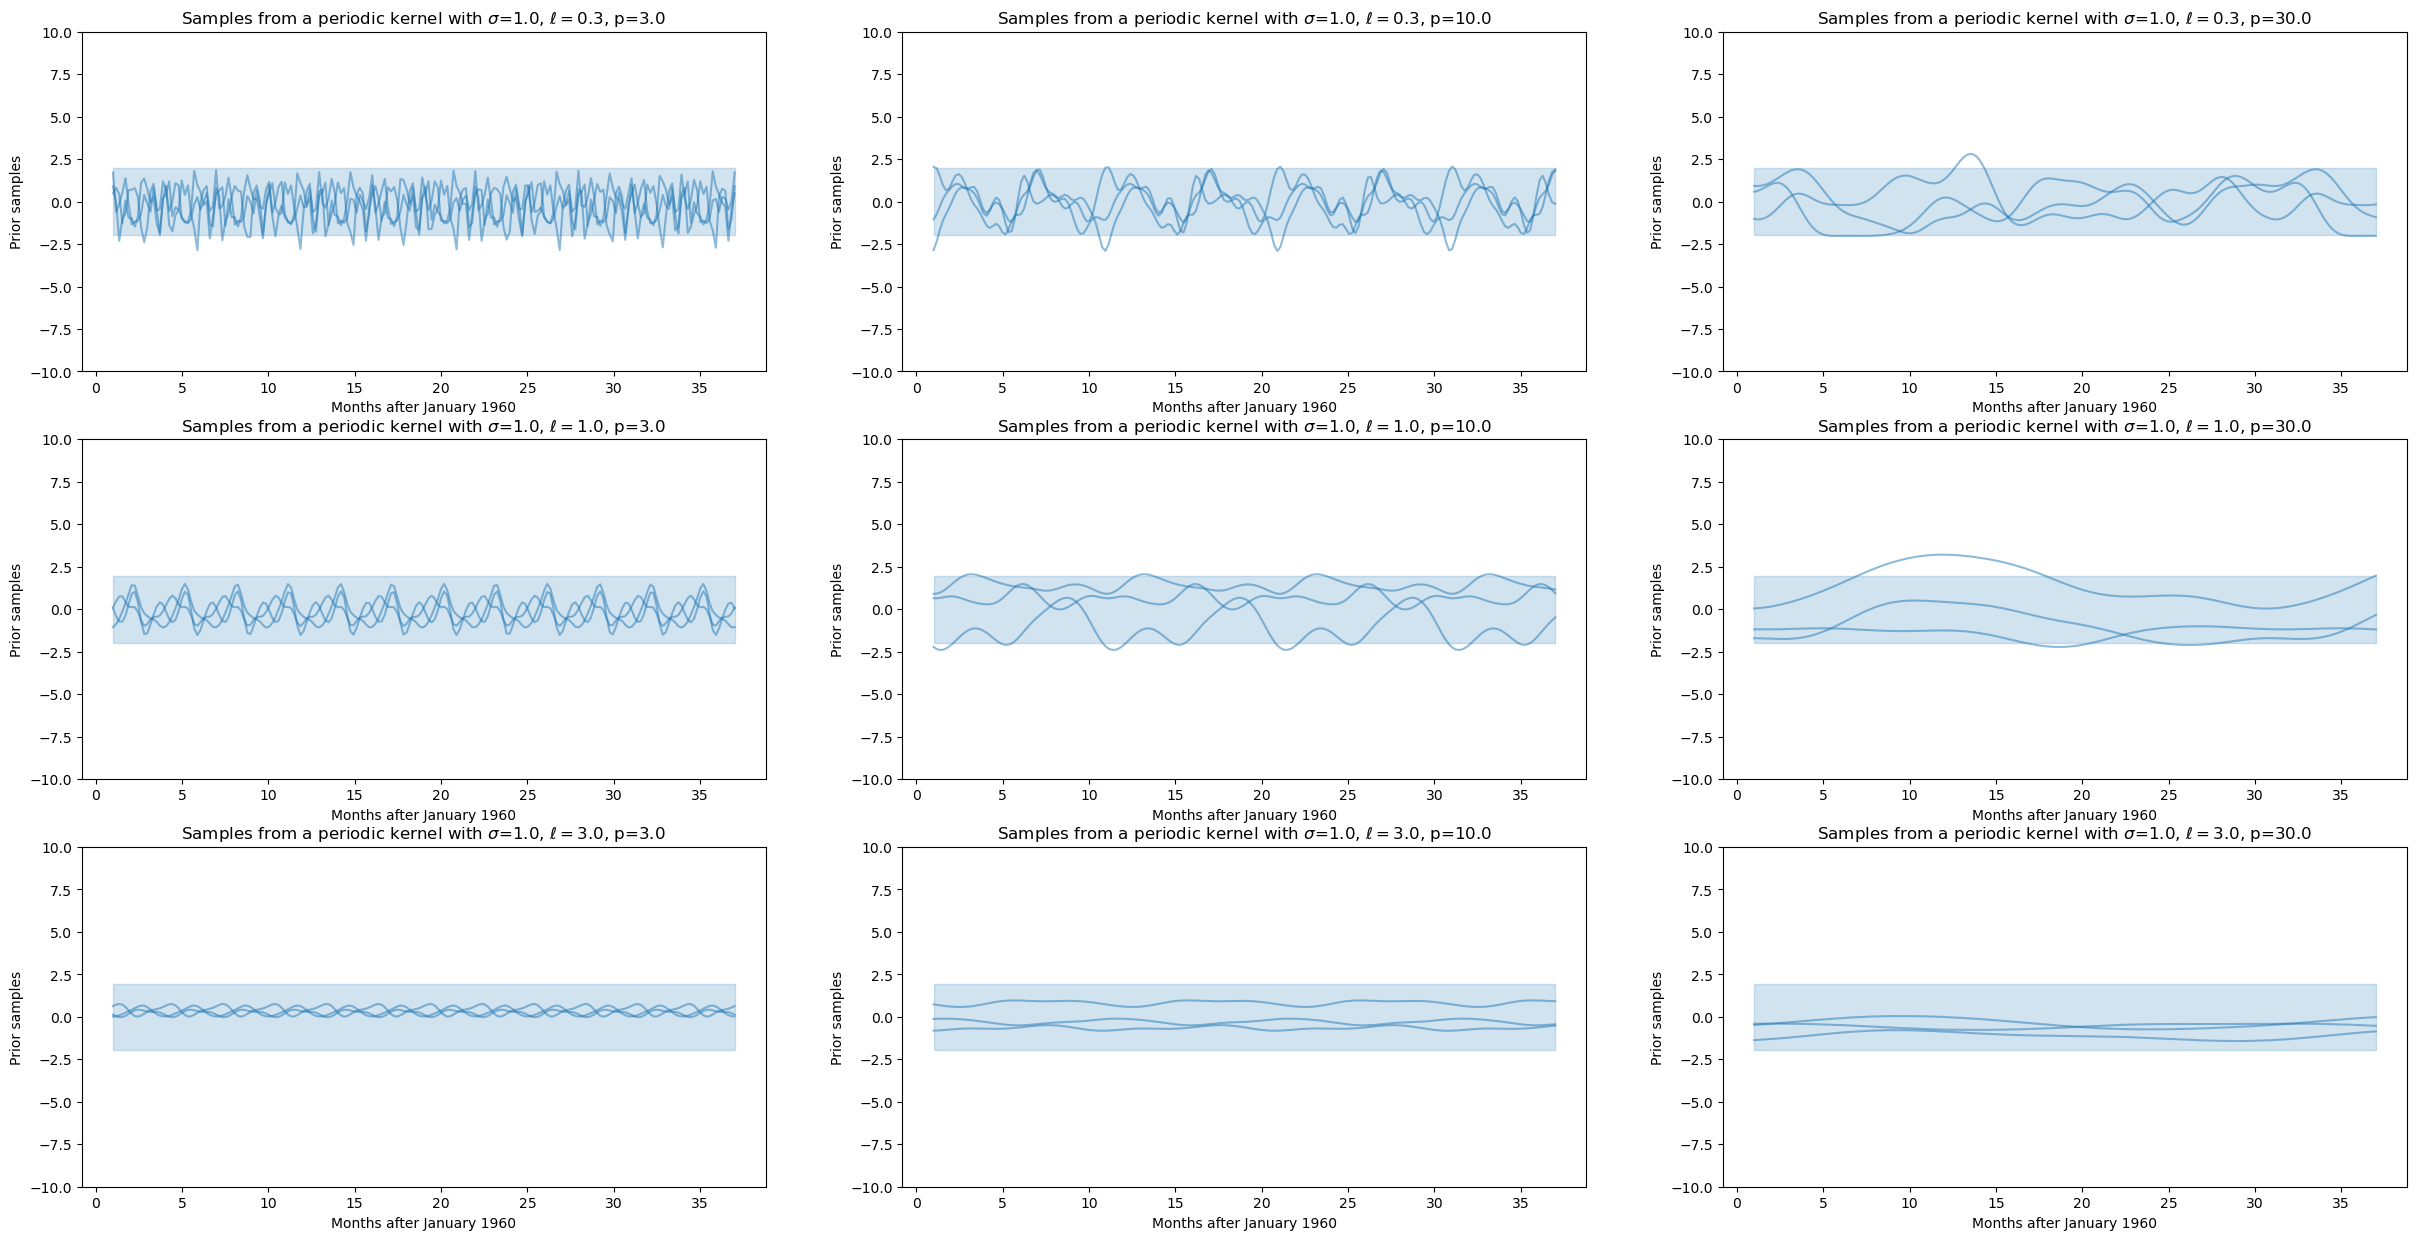

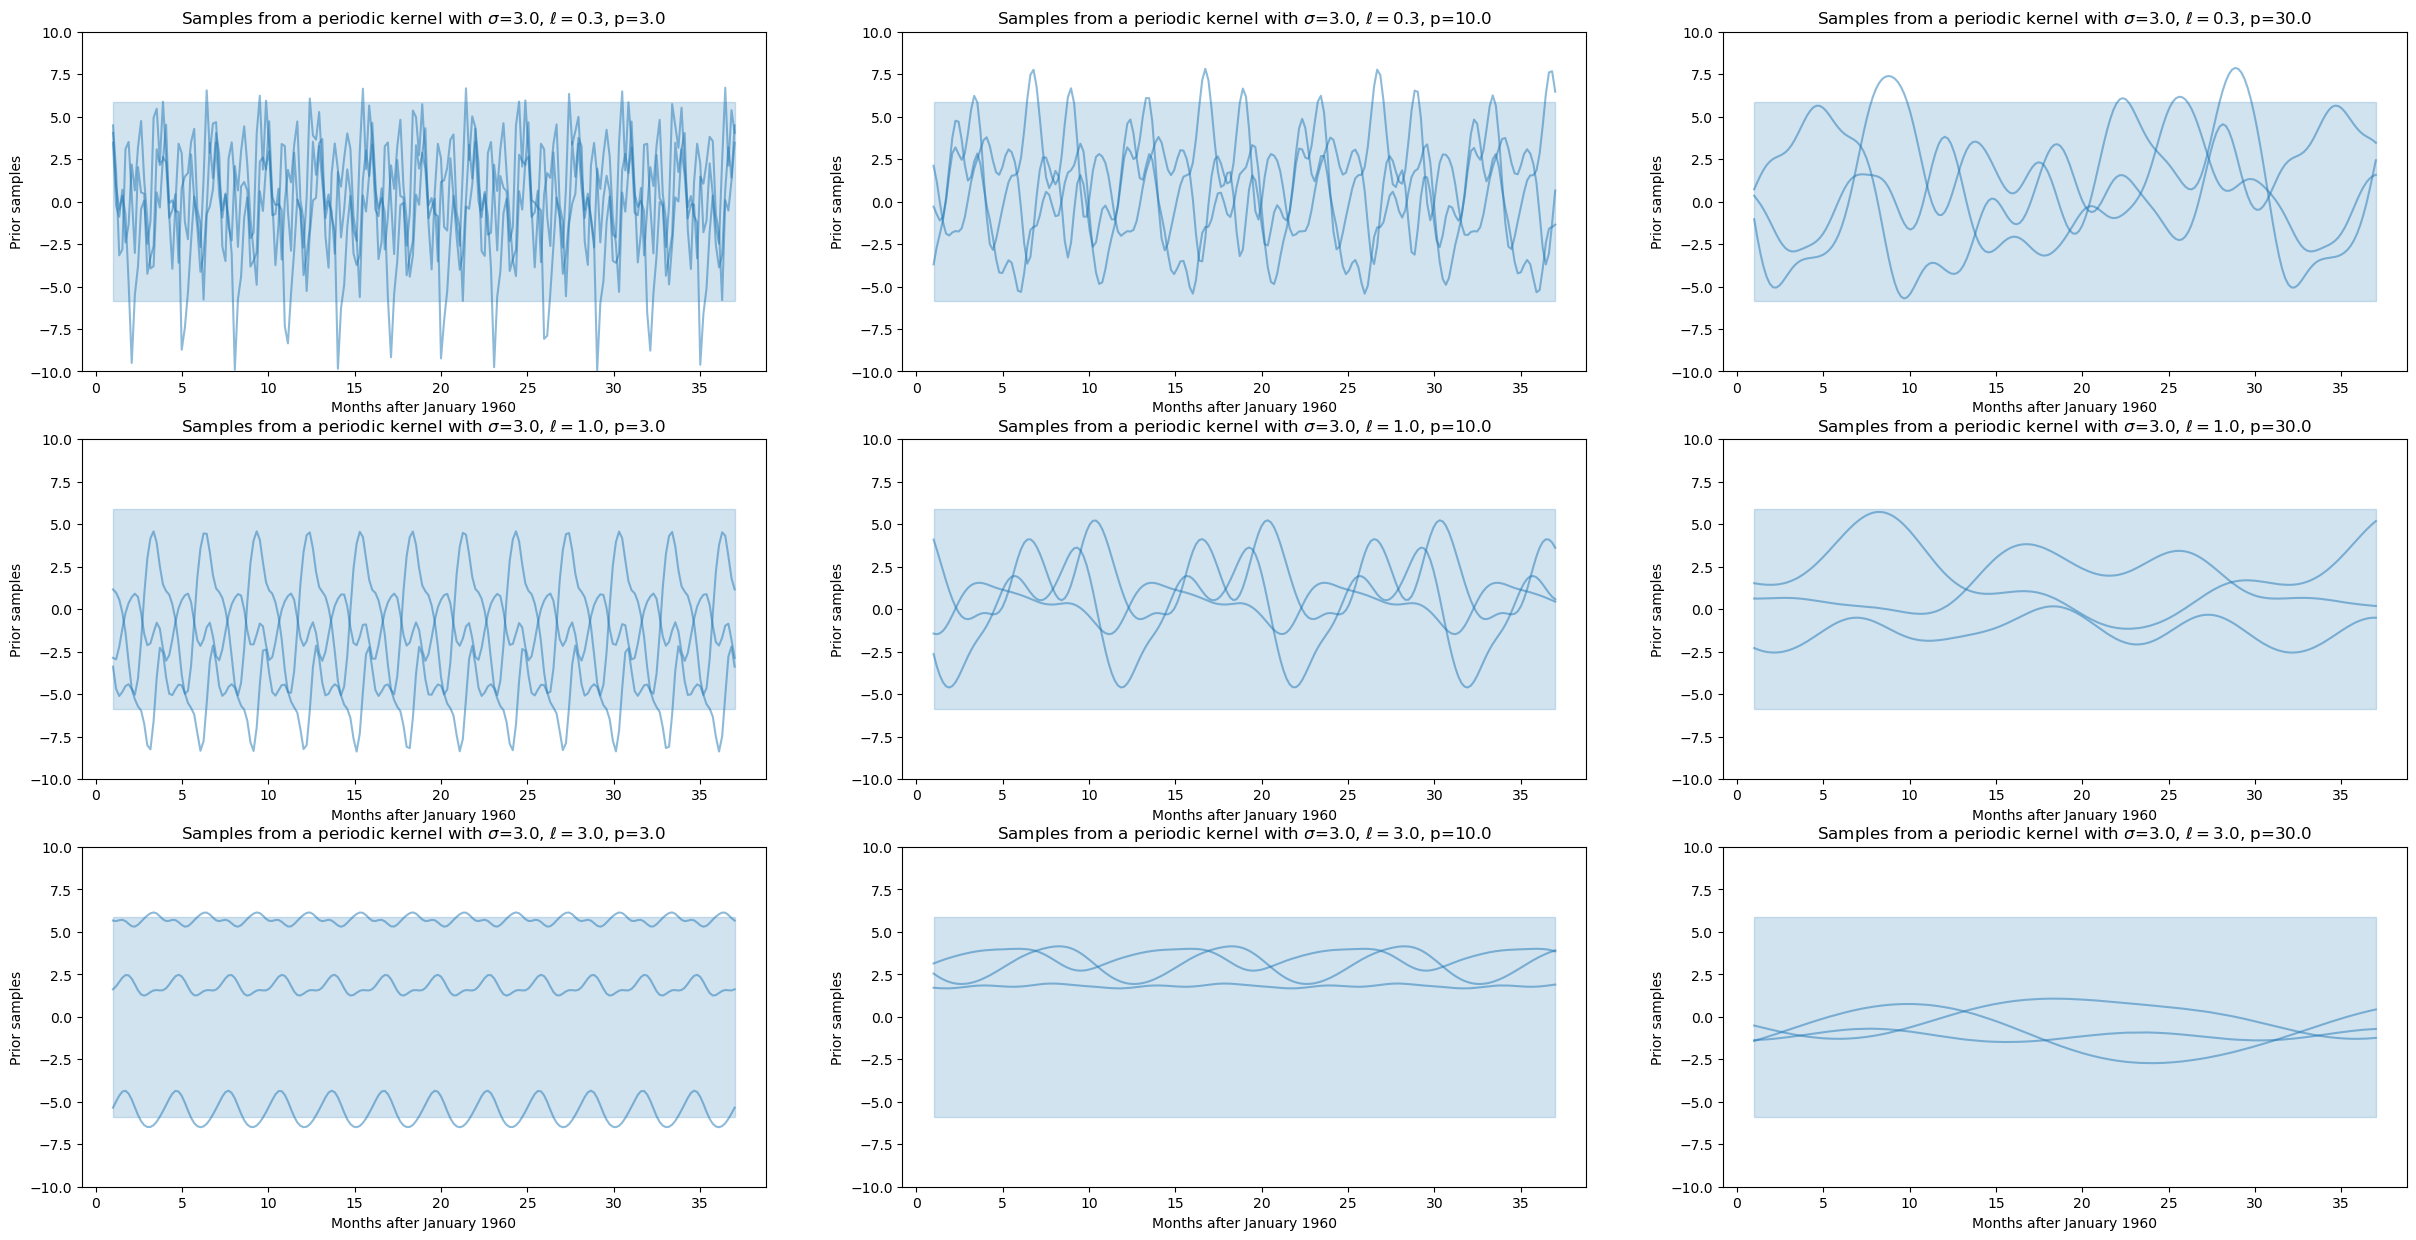

In [7]:
sigma_fs = [1.0, 3.0]
lengthscales = [0.3, 1.0, 3.0]
periods = [3.0, 10.0, 30.0]

for sigma_f in sigma_fs:
    fig, axs = plt.subplots(3, 3, figsize=(30, 15))
    for i, lengthscale in enumerate(lengthscales):
        for j, period in enumerate(periods):
            k = PeriodicKernel(sigma_f, lengthscale, period)
            # compute kernel matrix
            K = k(X)
            var = np.diag(K)
            # take cholesky decomposition K = LL^T
            # add small jitter 1e-6 for better matrix conditioning
            L = np.linalg.cholesky(K + 1e-6 * np.eye(K.shape[0]))
            # compute GP samples f_samples by f_samples = Lz, z~N(0,I)
            f_samples = L[None] @ np.random.normal(size=(n_samples, X.shape[0], 1))
            axs[i, j].plot(X, f_samples[:, :, 0].T, color="C0", alpha=0.5)
            axs[i, j].set_xlabel("Months after January 1960")
            axs[i, j].set_ylabel("Prior samples")
            axs[i, j].set_title(
                f"Samples from a periodic kernel with $\sigma$={sigma_f}, $\ell=${lengthscale}, p={period}"
            )
            axs[i, j].set_ylim(-10, 10)

            # plot the 95% confidence interval
            axs[i, j].fill_between(
                X[:, 0],
                -1.96 * np.sqrt(var),
                1.96 * np.sqrt(var),
                color="C0",
                alpha=0.2,
            )


Since we are using a GP with a zero-mean prior we minus the mean temperature from our response variable.


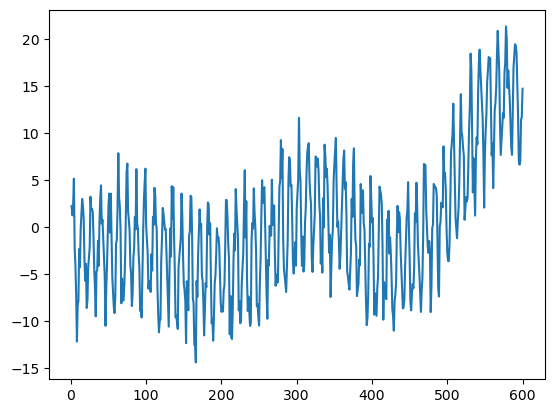

In [8]:
# format the data into matrices of the appropriate sizes
X = df["t"].values[:, None]
y = df["temp"].values[:, None]
mean_y = np.mean(y)
y -= mean_y

plt.plot(X, y)


Now we define three kernels (which define the GP models): a RBF kernel, a periodic kernel and a locally periodic kernel constructed as the mutliplication of a RBF and a periodic kernel. 

Since this is annual temperature data we will use a period of 12 months for the periodic parts of any kernels. The other kernel hyperparameters where chosen by maximising the marginal likelihood (code not shown here -- in a coursework, you would be expected to identify a good choice of hyperparamters by maximising the marginal likelihood).

Below are the three kernels we will use, including their hyperparameters.

In [9]:
kernel_functions = [
    # RBF kernel
    RBF(sigma_f=6.0, lengthscale=3.6),
    # periodic kernel
    PeriodicKernel(sigma_f=3.2, lengthscale=1.0, period=12.0),
    # RBF x Periodic
    RBF(sigma_f=1, lengthscale=10.0)
    * PeriodicKernel(sigma_f=3.2, lengthscale=1.0, period=12.0),
]


Now we fit the GP posterior for each model and calculate the marginal likelihood for each case assuming that the variance of the additive noise is equal to 1 (again in a coursework, this value should be optimized jointly with the other kernel hyperparameters):

In [10]:
SIGMA_N = 1.0

# Function to estimate the posterior mean and variance of the GP for a given kernel 
# where (X,y) are the training data and X_star are the test points
def fit_gp_posterior(
    X: np.ndarray, y: np.ndarray, X_star: np.ndarray, kernel: Kernel, sigma_n: float
) -> Tuple[np.ndarray]:
    """Returns the mean and variance of the GP posterior
    for data (X,y) and kernel function k_fn at test points X*
    sigma_n is the noise std
    """
    Kff = kernel(X)  # K(X,X)
    Kffs = kernel(X, X_star)  # K(X,X*)
    Kfsfs = kernel(X_star)  # K(X*,X*)

    # calculate posterior
    sigma_n_sq = sigma_n ** 2
    f_mean = Kffs.T @ np.linalg.solve(Kff + sigma_n_sq * np.eye(Kff.shape[0]), y)
    f_cov = Kfsfs - Kffs.T @ np.linalg.solve(
        Kff + sigma_n_sq * np.eye(Kff.shape[0]), Kffs
    )

    return f_mean, f_cov

# Function to compute the marginal likelihood of the GP for a given kernel
def log_marg_likelihood(
    X: np.ndarray, y: np.ndarray, kernel: Kernel, sigma_n: float
) -> float:
    Kff = kernel(X)  # K(X,X)
    A = Kff + sigma_n ** 2 * np.eye(Kff.shape[0])
    lml = -0.5 * (
        y.T @ np.linalg.solve(A, y)
        + np.log(np.linalg.det(A) + 1e-9)
        + X.shape[0] * np.log(2 * np.pi)
    )
    return lml[0, 0]


In [11]:
# Compute the posterior mean and variance for each of the three kernels
gp_posteriors = [
    fit_gp_posterior(X, y, np.linspace(0, 600, 1201)[:, None], kernel, SIGMA_N)
    for kernel in kernel_functions
]

In [12]:
#  Compute the marginal likelihood for each of the three kernels
all_lmls = [log_marg_likelihood(X, y, kernel, SIGMA_N) for kernel in kernel_functions]
all_lmls


[-1660.2107498841447, -9020.650580419835, -1572.4783949634073]

Plot the GP posterior with the marginal likelihoods. We plot the mean with a shaded area that represents a 95% credible interval.


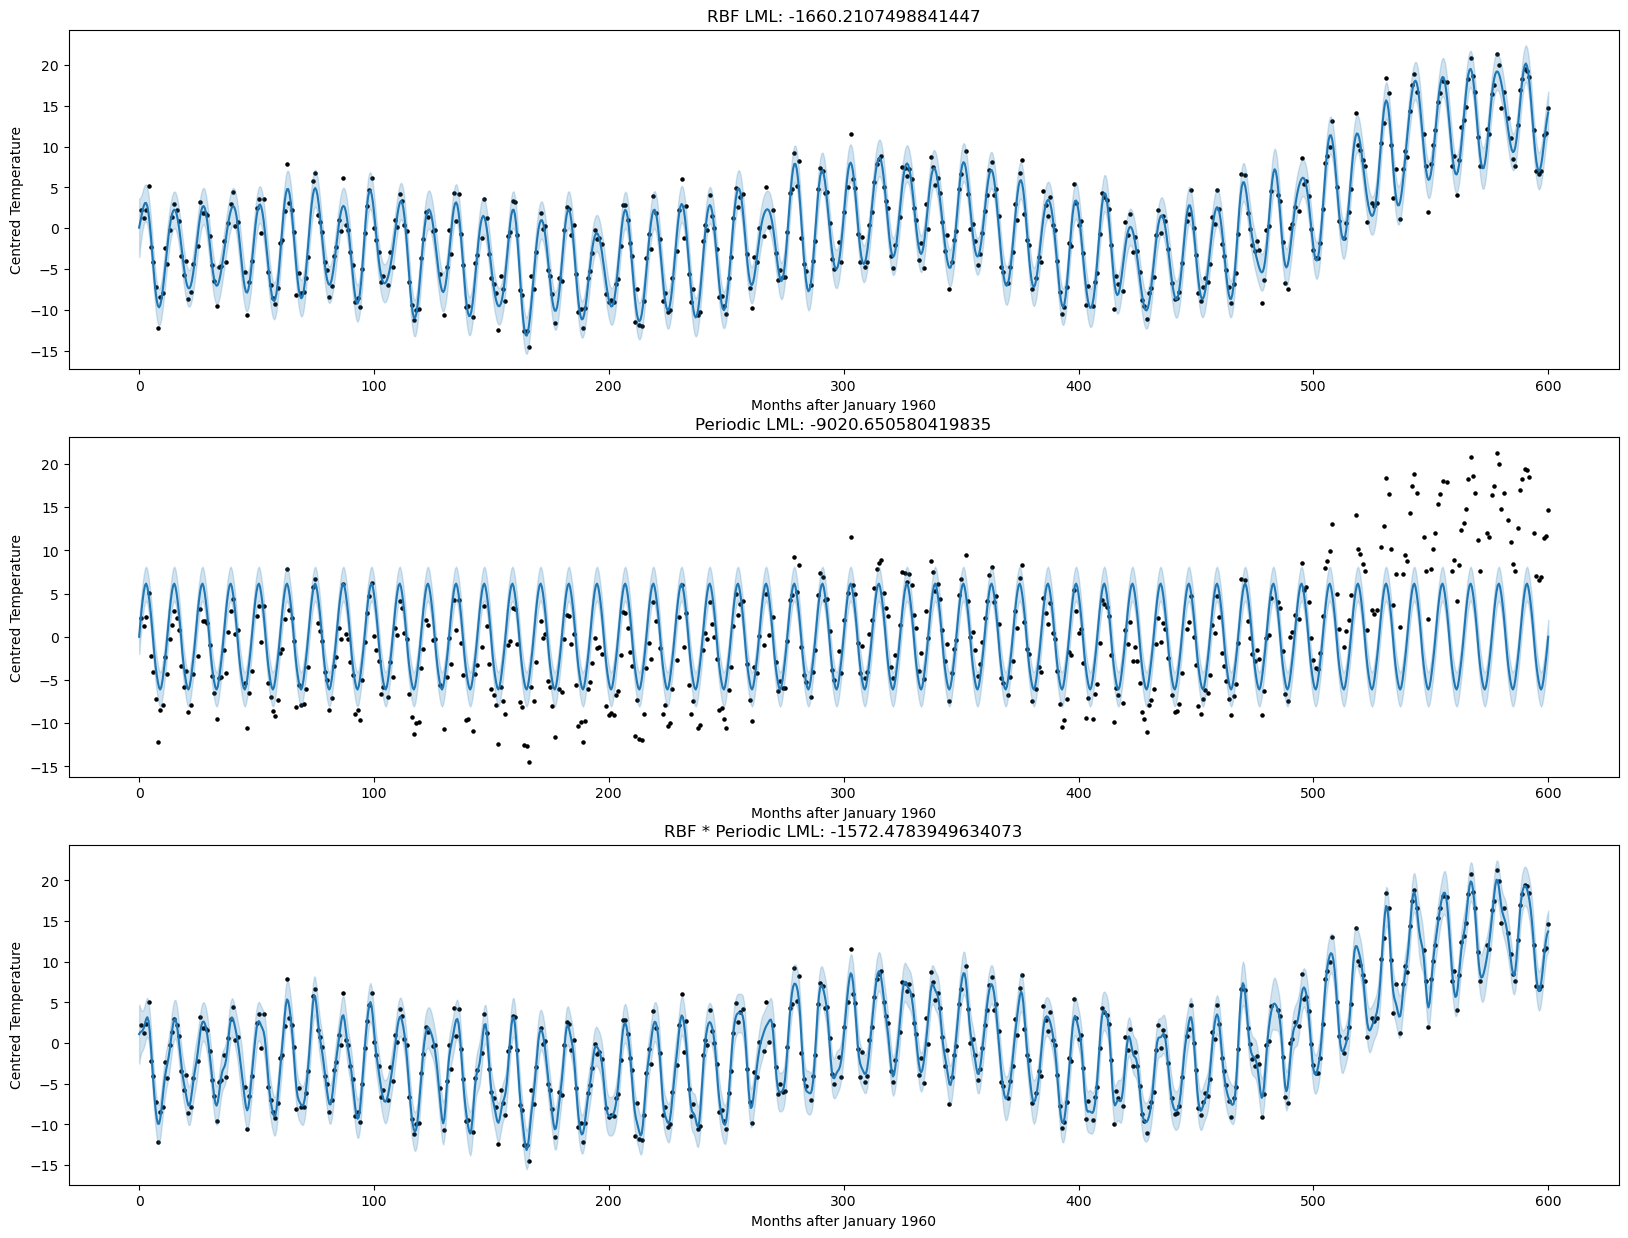

In [13]:
titles = ["RBF", "Periodic", "RBF * Periodic"]
x_plot = np.linspace(0, 600, 1201)[:, None]
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
for i, (f_mean, f_cov) in enumerate(gp_posteriors):
    lml = all_lmls[i]
    f_var = np.diag(f_cov)[:, None]
    axs[i].plot(x_plot, f_mean, color="C0")
    axs[i].scatter(X, y, color="black", s=5)
    axs[i].set_xlabel("Months after January 1960")
    axs[i].set_ylabel("Centred Temperature")
    axs[i].set_title(titles[i] + f" LML: {lml}")

    # plot the 95% predictive distribution (f_var + likelihood_variance)
    axs[i].fill_between(
        x_plot[:, 0],
        (f_mean - 1.96 * np.sqrt(f_var + SIGMA_N ** 2))[:, 0],
        (f_mean + 1.96 * np.sqrt(f_var + SIGMA_N ** 2))[:, 0],
        color="C0",
        alpha=0.2,
    )


We can see that the purely periodic kernel is not able to capture the increasing linear trend towards the end of the sequence. This is reflected in its marginal log-likelihood, which is the lowest of the three models.

If we extend the forecast beyond the data the uncertainty increases drastically - in the absence of data the GP reverts to its prior.

March 2011 corresponds to $t=615$.

In [14]:
Xs = np.linspace(577, 615, 39)[:, None]
y_615 = 36 - mean_y


In [15]:
gp_posteriors_with_pred = [
    fit_gp_posterior(X, y, Xs, kernel, SIGMA_N) for kernel in kernel_functions
]

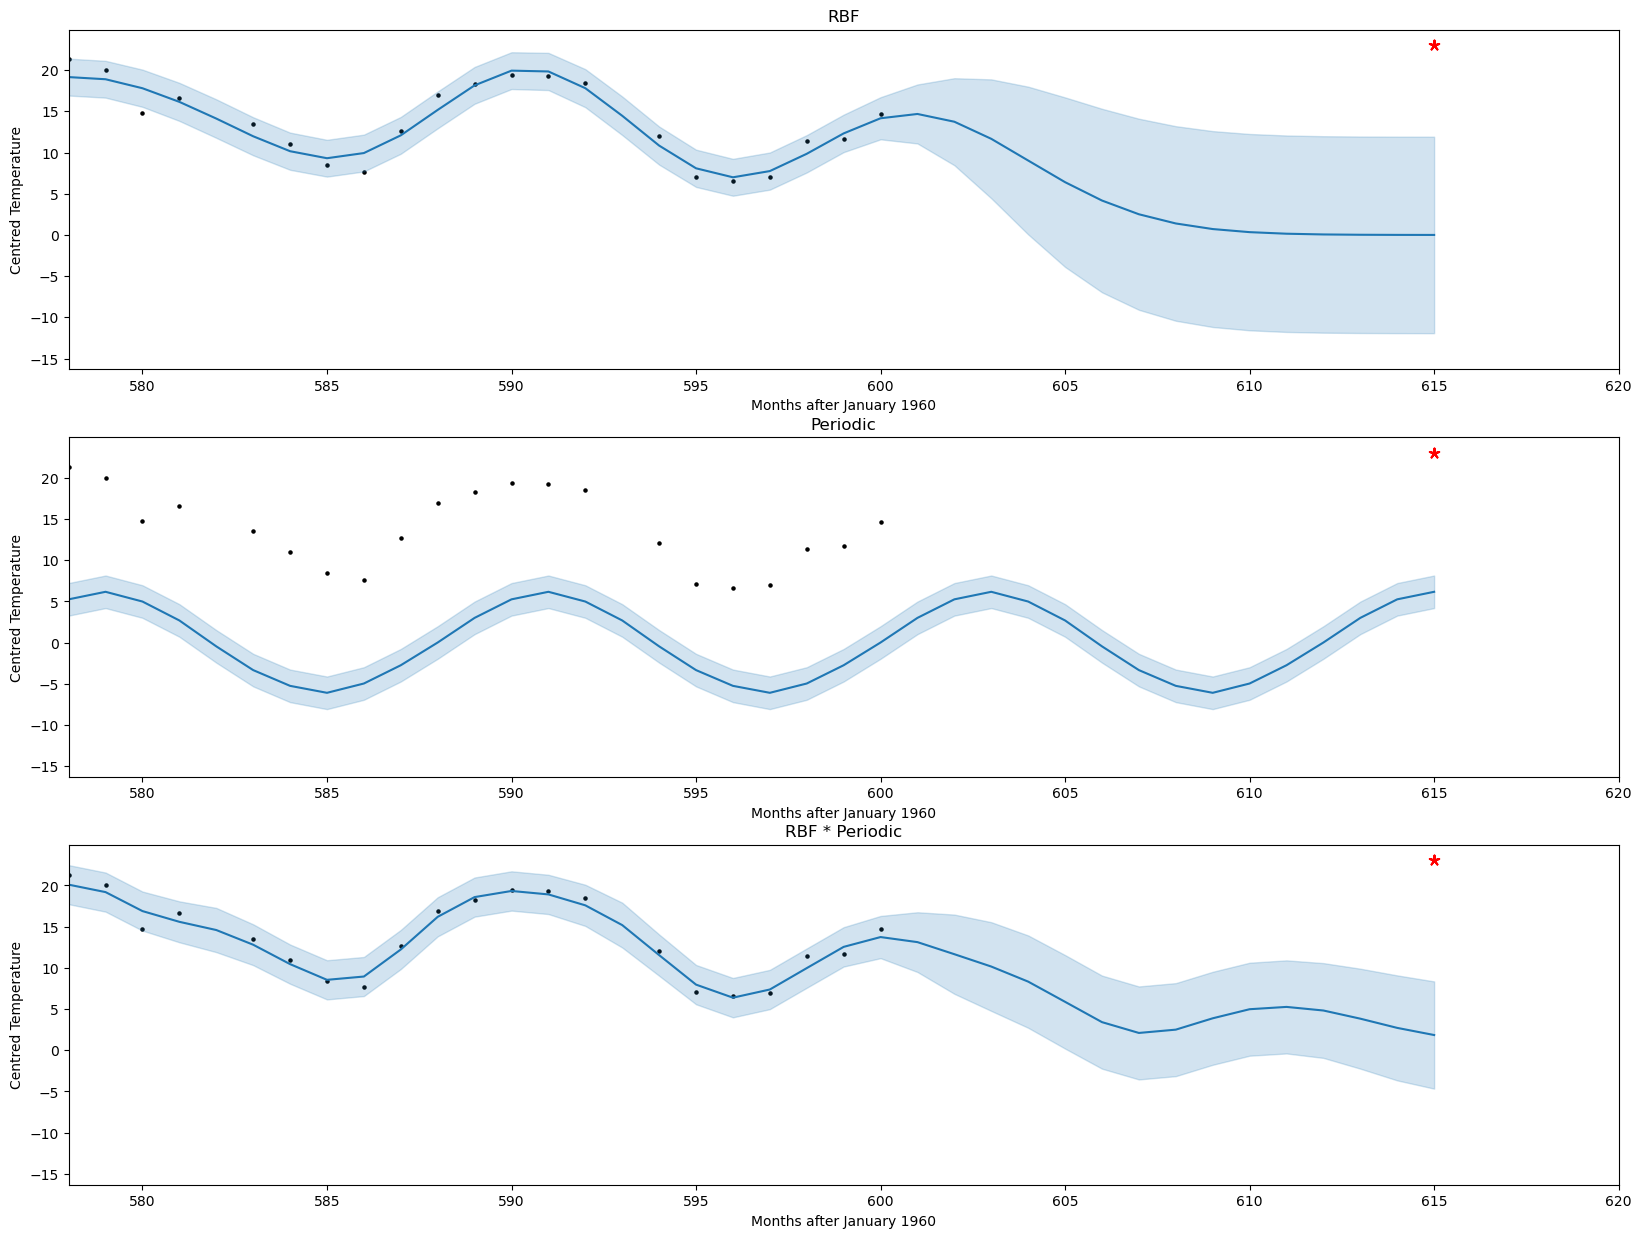

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
for i, (f_mean, f_cov) in enumerate(gp_posteriors_with_pred):
    lml = all_lmls[i]
    f_var = np.diag(f_cov)[:, None]
    axs[i].plot(Xs, f_mean, color="C0")
    axs[i].scatter(X, y, color="black", s=5)
    axs[i].scatter(615, y_615, color="red", s=50, marker=(5, 2))
    axs[i].set_xlabel("Months after January 1960")
    axs[i].set_ylabel("Centred Temperature")
    axs[i].set_title(titles[i])

    # plot the 95% predictive distribution (f_var + likelihood_variance)
    axs[i].fill_between(
        Xs[:, 0],
        (f_mean - 1.96 * np.sqrt(f_var + SIGMA_N ** 2))[:, 0],
        (f_mean + 1.96 * np.sqrt(f_var + SIGMA_N ** 2))[:, 0],
        color="C0",
        alpha=0.2,
    )
    axs[i].set_xlim(578, 620)


For each kernel, we can compute the posterior predictive mean and variance for March 2011 and compute the probability to observe a temperature as extreme higher or equal to 36 degrees in March 2011

In [17]:
Xs = np.array([[615]])
gp_posteriors_with_pred = [
    fit_gp_posterior(X, y, Xs, kernel, SIGMA_N) for kernel in kernel_functions
]


def compute_tail(mean, var):
    return 1 - norm(loc=mean, scale=np.sqrt(var)).cdf(y_615)[0][0]


In [18]:
tail_probs = [compute_tail(preds[0], preds[1]) for preds in gp_posteriors_with_pred]
tail_probs


[6.200228341968206e-05, 0.0, 1.0999756661078663e-11]

Note that due to the large amount of data, there is very low uncertainty in the Gaussian process prediction of the temperature during the observed period. If we were to fit the same Gaussian Processes on a smaller dataset with only 100 measurement of the temperature over the same period, we would obtain the plot below.

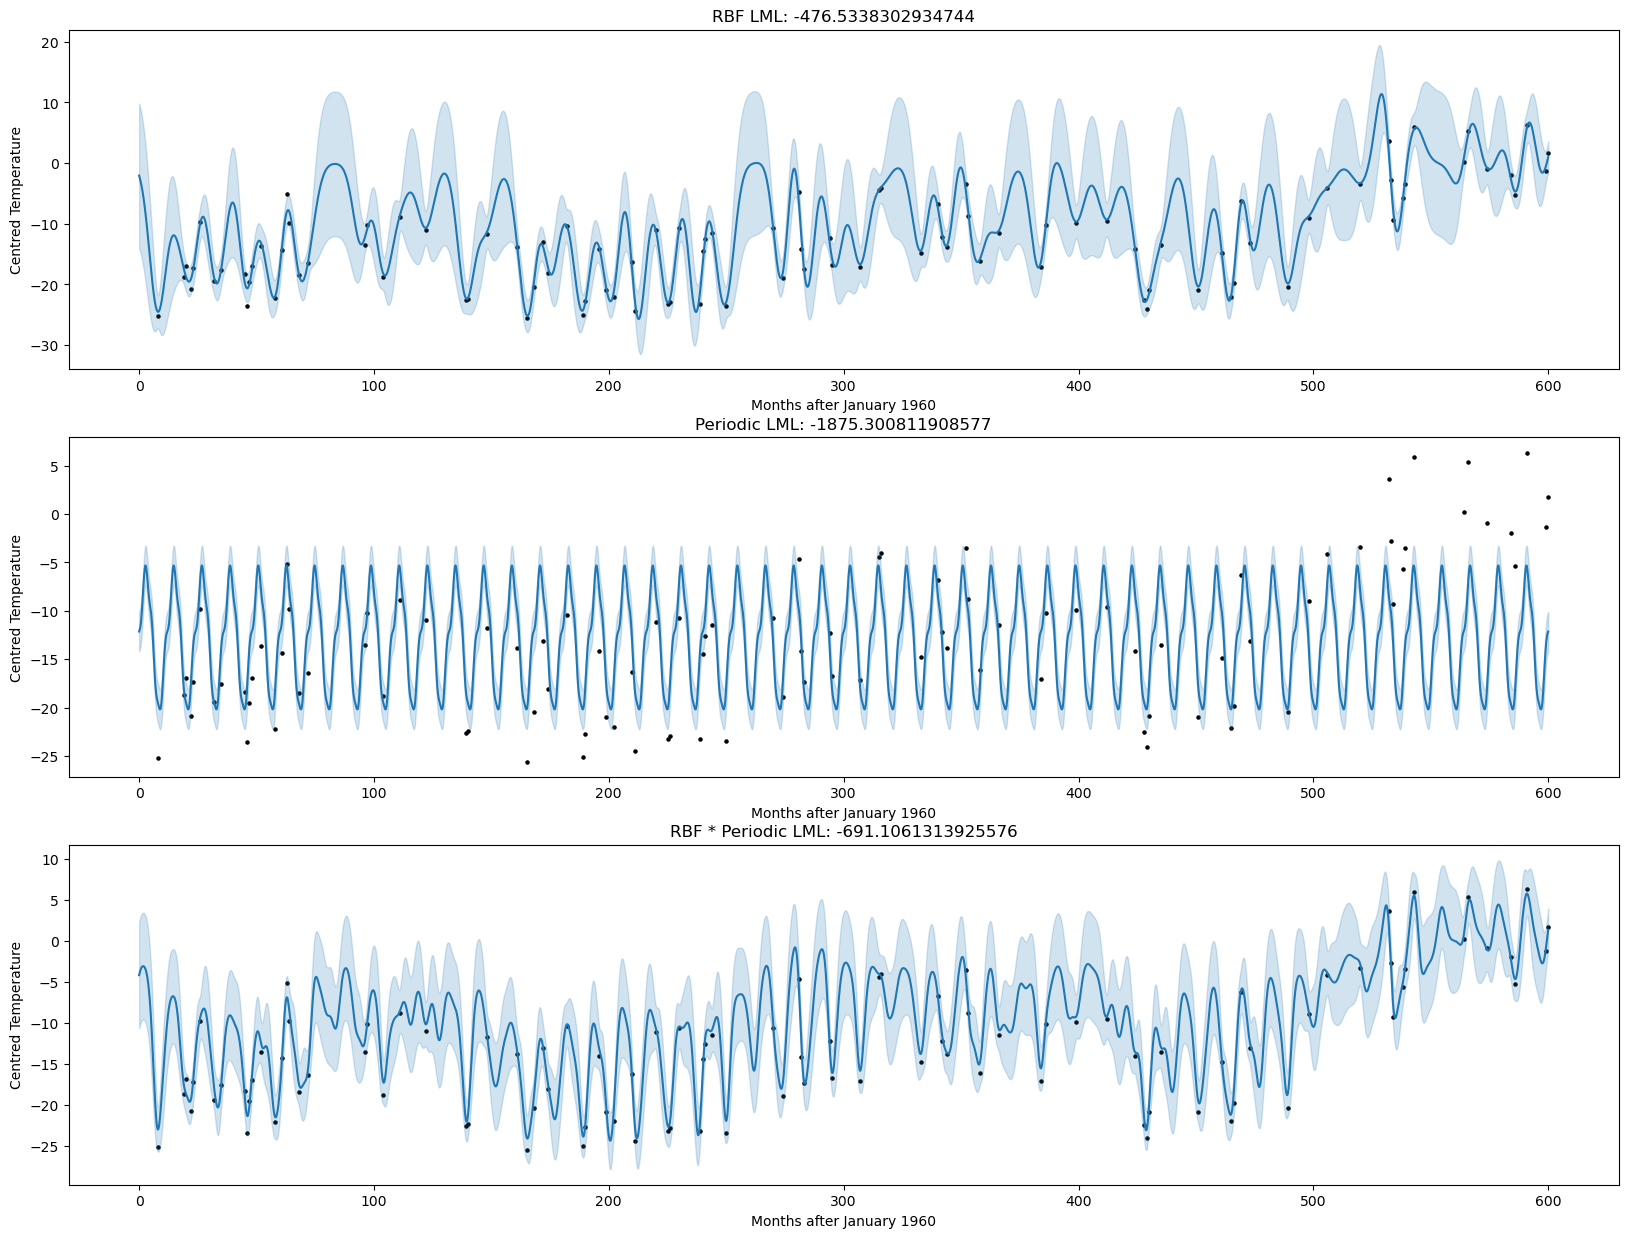

In [19]:
df_subsample = df.sample(n=100)
df_subsample = df_subsample.sort_values("t")
X = df_subsample["t"].values[:, None]
y = df_subsample["temp"].values[:, None]
y -= mean_y

gp_posteriors = [
    fit_gp_posterior(X, y, np.linspace(0, 600, 6001)[:, None], kernel, SIGMA_N)
    for kernel in kernel_functions
]
all_lmls = [log_marg_likelihood(X, y, kernel, SIGMA_N) for kernel in kernel_functions]

titles = ["RBF", "Periodic", "RBF * Periodic"]
x_plot = np.linspace(0, 600, 6001)[:, None]
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
for i, (f_mean, f_cov) in enumerate(gp_posteriors):
    lml = all_lmls[i]
    f_var = np.diag(f_cov)[:, None]
    axs[i].plot(x_plot, f_mean, color="C0")
    axs[i].scatter(X, y, color="black", s=5)
    axs[i].set_xlabel("Months after January 1960")
    axs[i].set_ylabel("Centred Temperature")
    axs[i].set_title(titles[i] + f" LML: {lml}")

    # plot the 95% predictive distribution (f_var + likelihood_variance)
    axs[i].fill_between(
        x_plot[:, 0],
        (f_mean - 1.96 * np.sqrt(f_var + SIGMA_N ** 2))[:, 0],
        (f_mean + 1.96 * np.sqrt(f_var + SIGMA_N ** 2))[:, 0],
        color="C0",
        alpha=0.2,
    )


There exist multiple packages to fit Gaussian Process in python such as:
* the one from scikit-learn: https://scikit-learn.org/stable/modules/gaussian_process.html
* GPytorch: https://gpytorch.ai/ 
* or GPflow: https://gpflow.github.io/GPflow/develop/index.html 

As for any package, if you decide to use one of them, you should carefully read the documentation and ensure that you fully understand what it does and which choices assumptions/statistical choices are made.